# *refellips* 
### Example: 55 nm thick Au thin film at 65°

Based on the [official refellips demos](https://refellips.readthedocs.io/en/main/examples.html)

### Packages needed to do the fitting

In [3]:
from pprint import pprint # To see de attributes of the objects defined on refellips

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
import refellips
from refellips.dataSE import DataSE
from refellips.reflect_modelSE import ReflectModelSE
from refellips.objectiveSE import ObjectiveSE
from refellips.dispersion import RI
from refellips import load_material

In [6]:
import refnx
from refnx.analysis import CurveFitter

In [7]:
print(
    f"refellips: {refellips.version.version}\nrefnx: {refnx.version.version}\nnumpy: {np.version.version}"
)

refellips: 0.0.6
refnx: 0.1.60
numpy: 2.3.3


### Import raw data from a CSV fiile: (wavelength , angle of incidence, psi, delta)

In [9]:
file = "Bk7Au.csv" # CSV: wavelength, aoi, psi, delta
data = DataSE(data=file, delimiter = ",") # Commas separated values (CSV) file
                                          # Specific data can be recovred with the following flags: .data, .wavelenght, .aoi, .psi, .delta
                                          # More: https://refellips.readthedocs.io/en/main/refellips.dataSE.html

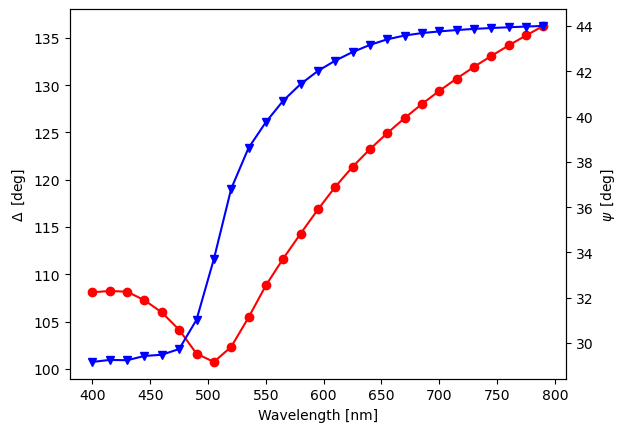

In [10]:
fig, ax = plt.subplots() 
axt = ax.twinx()

ax.plot(data.wavelength, data.delta, ls = '-', color = 'r', marker = "o")
axt.plot(data.wavelength, data.psi, ls = '-', color = 'b', marker = "v")
ax.set(ylabel=r'$\Delta\,$ [deg]', xlabel=r"Wavelength [nm]")
axt.set(ylabel=r"$\psi\,$ [deg]");

### Building the stratified systems

To build the multilayer system, information on the refractive index  $n$ of the materials is needed. This is given by the object: [refellips.dispersion()](https://refellips.readthedocs.io/en/main/refellips.dispersion.html)

#### Dispersion models 
- Several disperssion models are defined in *refellips* 
- Depending on the employed model, the parameters are represented in different units.
- To expand the library on disperssion models include them in `$VENV/lib/python3.13/site-packages/refellips/dispersion.py`

#### Experimental data
- Avialable with the function `load_material()`, which is itself part of `refellips.dipsersion()`
- Some experimental data are included in the *refellips* distribution but it is not clear from which source are they specifically.
- To add more data a CVS file (with header) is used with the 1st columns the wavelength (um), the 2nd the real part of the refrative index and, if a 3rd one is included, the imaginary part of the refractive index.
- The past files must be saved in `$VENV/lib/python3.13/site-packages/refellips/materials`

In [10]:
glass = RI([1.5,0.])         # Constant refractive index $n$ with Re(n) = 1.5 and Im(n) = 0.0
gold = load_material("gold") #  Included experimental data of gold (au) in bulk. Probably Johnson & Christy data
air = RI([1.,0.])

glass.name = "Glass"
gold.name = "Au"
air.name = "Air"

# The thickness of layers are given in Angstroms. 
# A first estimate of the thickness is needed to build the model
gold_layer = gold(350.)  # Estimated thickness of the sample (350 angstroms  = 35 nm)
gold_layer.thick.setp(vary=True, bounds=(50., 1000.)) # A flat surfaces is assumed. It is stated that the thickness can be varied and a ranged for it is defined

struc = air() | gold_layer | glass() # The structure of the system is defined with the refractive indices give at the begining. The first (fronting/incidence) and last (backing/transmition) materials
                                     # are assumed to be infinite, thus no thickness is requiere. Any other materila is finite
model = ReflectModelSE(struc)

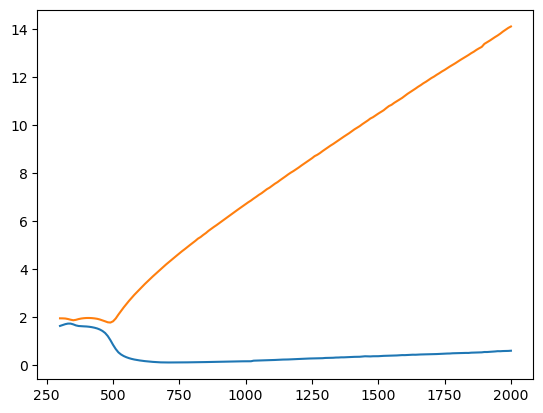

In [11]:
# To see al availabe data fro the refractive indices use pprint(vars(gold))
fig, ax = plt.subplots() 
ax.plot(gold._wav, gold._RI, gold._wav, gold._EC)

## Ajuste de datos
### Modelo y primera iteración

In [21]:
# Retrive the data from the CSV file
lda, aoi, d_psi, d_delta = data.data

# Calculate the ellipsometric parameters with the Transfere Matrix Method used in refellips
# The model is defined above as 
# model = ReflectModelSE(struc)
psi, delta = model(np.c_[np.ones_like(aoi) * lda, aoi])

hw = 1420/lda  # Photon energy for each wavelength

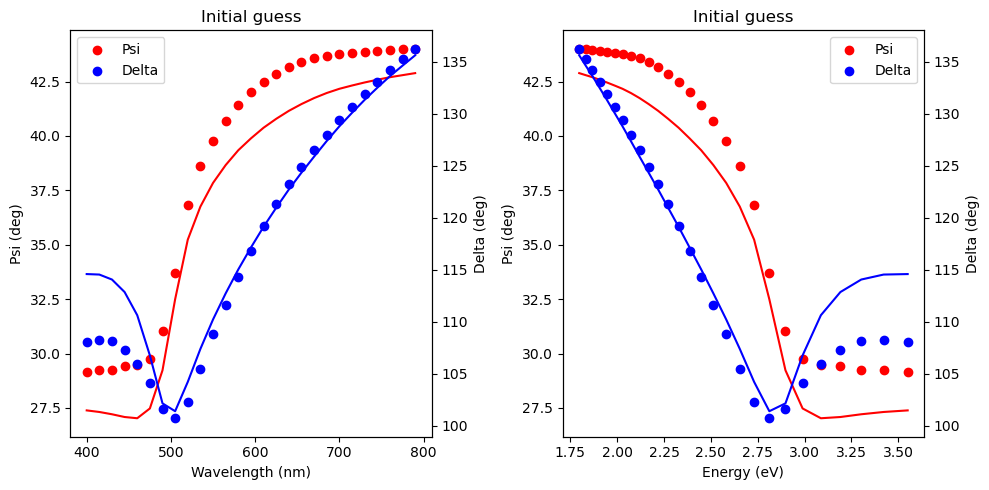

In [22]:
# Create a figure with 1 rows and 2 columns of subplots
fig, ax = plt.subplots(1,2,figsize=(10, 5))
axtlda = ax[0].twinx()
axteV = ax[1].twinx()

ax[0].plot(lda, psi, ls = '-', color = 'r',)
ax[1].plot(hw, psi, ls = '-', color = 'r',)
axtlda.plot(lda, delta, ls = '-', color = 'b',)
axteV.plot(hw, delta, ls = '-', color = 'b')

plda = ax[0].scatter(lda, d_psi, color="r", marker = 'o')
dlda = axtlda.scatter(lda, d_delta, color="b", marker = 'o')
peV = ax[1].scatter(hw, d_psi, color="r", marker = 'o')
deV = axteV.scatter(hw, d_delta, color="b", marker = 'o')

ax[0].legend(handles=[plda, dlda], labels=["Psi", "Delta"])
ax[1].legend(handles=[peV, deV], labels=["Psi", "Delta"])

ax[0].set(ylabel="Psi (deg)", xlabel="Wavelength (nm)", title="Initial guess")
ax[1].set(ylabel="Psi (deg)", xlabel="Energy (eV)", title="Initial guess")
axtlda.set(ylabel="Delta (deg)");
axteV.set(ylabel="Delta (deg)");

fig.tight_layout()

In [23]:
# ObjectiveSE function
# To retrieve fara from the model and the actual data

objective = ObjectiveSE(model, data)
objective.residuals()

array([-1.77927467, -1.94048456, -2.03104483, -2.34657304, -2.45617307,
       -2.26016193, -1.79694762, -1.21095984, -1.58130622, -1.86141514,
       -1.9144612 , -2.04113887, -2.09185566, -2.12770659, -2.09520933,
       -2.06308584, -2.01256962, -1.94780082, -1.8397482 , -1.71479076,
       -1.59520244, -1.50445125, -1.41440314, -1.32892464, -1.24610648,
       -1.18297372, -1.11736406,  6.50199042,  6.31852431,  5.91678693,
        5.61603808,  4.67480489,  2.64620727,  0.55487821,  0.67747842,
        1.90171412,  1.97145746,  1.40895047,  1.08614086,  0.75234091,
        0.30082795,  0.09911715,  0.39021561,  0.49884608,  0.5755605 ,
        0.62198192,  0.6081292 ,  0.58539077,  0.59399035,  0.57529801,
        0.57543497,  0.56547414,  0.61036229,  0.62238307])

### Fitting

In [27]:
fitter = CurveFitter(objective)
fitter.fit(method="least_squares");

Text(700, 29, 'Model with refined\nparameters')

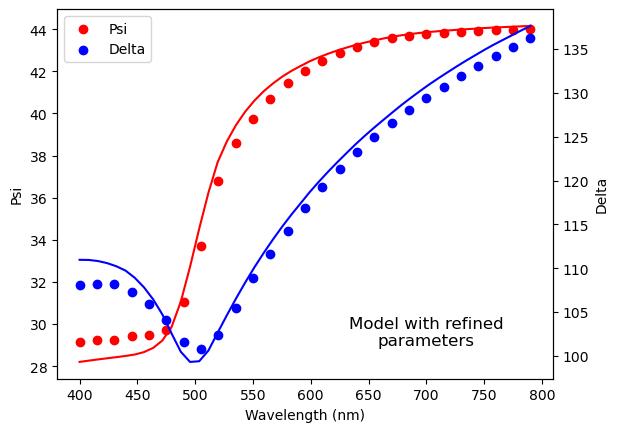

In [28]:
fig, ax = objective.plot()
ax.text(700, 29, "Model with refined\nparameters", ha="center", fontsize=12)

In [29]:
for i, x in enumerate(objective.model.parameters):
    print(x)

________________________________________________________________________________
Parameters: 'instrument parameters'
<Parameter:'delta offset' , value=0  (fixed) , bounds=[-inf, inf]>
________________________________________________________________________________
Parameters: 'Structure - ' 
________________________________________________________________________________
Parameters:      'Air'     
<Parameter: 'Air - thick' , value=0  (fixed) , bounds=[-inf, inf]>
<Parameter: 'Air - rough' , value=0  (fixed) , bounds=[-inf, inf]>
<Parameter:'Air - volfrac solvent', value=0  (fixed) , bounds=[0.0, 1.0]>
________________________________________________________________________________
Parameters:      'Au'      
<Parameter: 'Au - thick'  , value=531.248 +/- 22.6 , bounds=[50.0, 1000.0]>
<Parameter: 'Au - rough'  , value=0  (fixed) , bounds=[-inf, inf]>
<Parameter:'Au - volfrac solvent', value=0  (fixed) , bounds=[0.0, 1.0]>
_________________________________________________________________